<a href="https://colab.research.google.com/github/chenghan0516/FakeNewsDetection/blob/master/BERT_(with_sentiment).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顯示GPU

In [ ]:
!nvidia-smi

#環境建置：

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/My Drive/FakeNewsNet/
!pip install transformers

import os
import pandas as pd
import numpy as np
import json
import heapq
import matplotlib.pyplot as plt
# subject="politifact"
subject="gossipcop"
path = "Bert (with sentiment)"
save_every_pt = 1000
if not os.path.isdir('{}/current'.format(path)):
  os.makedirs('{}/current'.format(path))

#進度顯示用函式：

In [ ]:
import time
import math
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)
def timeSince(since, percent):
  now = time.time()
  s = now - since
  if percent!=0:
    es = s / (percent)
    rs = es - s
    return "%s (- %s)" % (asMinutes(s), asMinutes(rs))
  else:
    return "%s (- INF)" % (asMinutes(s))

def progress(start, cur, total_len, loss, cur_read=0):
  print("{} ({}%)\nloss = {}".format(
    timeSince(start,(cur-cur_read) / (total_len-cur_read)),
    (cur / total_len)* 100,
    loss
    )
  )

#模型：

In [ ]:
#------------------------------------------------------------------------------- training shits -------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GRU_HIDDEN_SIZE=128

#Sentiment Model
class Sentiment(nn.Module):
  def __init__(self):
    super(Sentiment, self).__init__()
    self.gru = nn.GRU(
        input_size=768,
        hidden_size=128,
        dropout=0.3,
        num_layers=1,
        bidirectional=True,
    )
    self.FC_1 = nn.Linear(128,64)
    self.FC_2 = nn.Linear(64,16)
    self.FC_3 = nn.Linear(16,1)
  def forward(self, cls_vector):
    _, hidden = self.gru(cls_vector)
    embed = hidden[-1]

    # print(newsEmbed)
    output = self.FC_1(embed.to(device))
    sentiment_embed = output
    output = self.FC_2(F.relu(output))
    output = self.FC_3(F.relu(output))

    return output,sentiment_embed

# Bert-Embedding
class BiGRU(nn.Module):
  def __init__(self):
    super(BiGRU, self).__init__()
    self.embedding = BertModel.from_pretrained('bert-base-uncased')
    self.sentiment_embed = torch.load(path+"/sentiment/Sentiment_model_221000.pt")
    self.gru = nn.GRU(
        input_size=768+64,
        hidden_size=GRU_HIDDEN_SIZE,
        dropout=0.3,
        num_layers=1,
        bidirectional=True,
    )

  def forward(self, tokens, masks=None):
    # BERT
    embedded = self.embedding(tokens, attention_mask=masks)["last_hidden_state"]
    cls_vector = embedded[:,0,:].reshape(-1,1,768)
    # sentiment
    s_embed = torch.tensor([[[0]*64]]).to(device);
    for i in cls_vector:
      s_embed_temp =self.sentiment_embed(i.view(1,1,-1))[1]
      s_embed = torch.cat((s_embed,s_embed_temp.view(1,1,64)),0)
    cls_vector = torch.cat((cls_vector, s_embed[1:].to(device)), 2)

    # GRU
    _, hidden = self.gru(cls_vector)

    return hidden[-1]

#Fake News Detector
class FakeNewsDetection(nn.Module):
  def __init__(self):
    super(FakeNewsDetection,self).__init__()
    self.bertEmbed = BiGRU()
    self.FC_1 = nn.Linear(GRU_HIDDEN_SIZE,64)
    self.FC_2 = nn.Linear(64,16)
    self.FC_3 = nn.Linear(16,1)

  def forward(self, titles, texts):
    count = 0
    titleEmbed = torch.zeros(GRU_HIDDEN_SIZE).to(device)
    textEmbed = torch.zeros(GRU_HIDDEN_SIZE).to(device)
    newsEmbed = torch.zeros(GRU_HIDDEN_SIZE).to(device)
    if len(titles)!=0:
      titleEmbed = self.bertEmbed(titles)
      count+=1
    if len(texts)!=0:
      textEmbed = self.bertEmbed(texts)
      count+=1
    if count!=0:
      newsEmbed = (titleEmbed+textEmbed)/count
    
    output = self.FC_1(newsEmbed.to(device))
    output = self.FC_2(F.relu(output))
    output = self.FC_3(F.relu(output))

    return F.sigmoid(output)


#訓練部分

##訓練用函式(輸入一篇新聞)：

In [ ]:
max_sentence_num = 5000
def train(train_model,X,y,optimizer,loss_func):
  optimizer.zero_grad()
  predict = train_model(torch.tensor(eval(X[0])[:max_sentence_num]).to(device),torch.tensor(eval(X[1])[:max_sentence_num]).to(device))
  loss = loss_func(predict.view(1), torch.tensor([y]).to(device))
  # print("predict: {}\nans:     {}\n loss: {}".format(predict,torch.tensor([y]),loss))
  loss.backward()
  optimizer.step()
  return predict,loss.item()

def train_model(token_data_read,train_index, test_index,cur_read=-1):
  FND_model = FakeNewsDetection().to(device)
  optimizer = optim.Adam(FND_model.parameters(), lr=0.0001)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
  if if_continue:
    FND_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

  loss_func = nn.BCELoss()
  FND_model.train()
  losses=[]
  cur = 0
  start = time.time()
  freezed_bert_layer_num_temp = freezed_bert_layer_num

  if if_continue: #若接續訓練
    f = open('{}/current/fold_{}/loss.txt'.format(path,fold), 'a')
  else: #若非接續訓練
    f = open('{}/current/fold_{}/loss.txt'.format(path,fold), 'w')
  for epoch in range(EPOCH):
    #Freeze layers
    modules = [FND_model.bertEmbed.embedding, FND_model.bertEmbed.sentiment_embed]
    for module in modules:
      for param in module.parameters():
        param.requires_grad = False
    if epoch>=end_warmup:
      modules = [FND_model.bertEmbed.embedding.encoder.layer[freezed_bert_layer_num_temp:]]
      for module in modules:
        for param in module.parameters():
          param.requires_grad = True
      if progressive_unfreeze:
        freezed_bert_layer_num_temp-=1
    #迭代訓練資料
    for i in train_index:
      #走到上次進度
      if cur<=cur_read:
        cur+=1
        continue
      #訓練BERT時跳過過長的文章
      if epoch>=10 and len(eval(token_data_read[random_index[i]][1]))>200:
        print("skip: {}".format(len(eval(token_data_read[random_index[i]][1]))))
        continue

      #訓練
      predict,loss = train(FND_model,token_data_read[random_index[i]][:2],float(token_data_read[random_index[i]][2]),optimizer,loss_func)
      losses.append(loss)

      #紀錄模型
      if cur!=0 and cur % save_every_pt==0:
        #模型
        print("start save checkpoint")
        torch.save({'cur':cur,
                    'model_state_dict':FND_model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict()}, '{}/current/fold_{}/FND_model_{}.pt'.format(path,fold,cur))
        #loss
        print("start save loss")
        for i in losses:
          f.write(str(i)+"\n")
        losses=[]
        #更新progress
        print("start save progress")
        with open('{}/current/train_progress.json'.format(path), 'w') as progress_json_file:
            json.dump({'fold':fold,'cur':cur}, progress_json_file)
        print("done saving")
      
      #顯示進度
      if cur % 10==0:
        progress(start,cur,train_index.shape[0]*EPOCH,loss, cur_read)
      cur+=1

    if cur>cur_read:
      scheduler.step()
  f.close()

  f = open('{}/current/fold_{}/loss.txt'.format(path,fold), 'r')
  losses = [float(i) for i in list(f.read().split("\n")[:-1])]
  f.close()
  plt.plot(range(len(losses)),losses)
  plt.savefig('{}/current/fold_{}/loss.png'.format(path,fold))
  plt.show()
  return losses

##訓練前讀檔：

In [ ]:
from sklearn.model_selection import KFold
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
token_data_read_pd = pd.read_csv(path+"/"+subject+"_token_data_bert_train.csv")
# token_data_read_pd_temp = token_data_read_pd[token_data_read_pd["text_len"]<500]
token_data_read = token_data_read_pd.to_numpy()

if_continue = os.path.isfile('{}/current/train_progress.json'.format(path))
if if_continue:
  with open('{}/current/train_progress.json'.format(path), 'r') as progress_json_file:
    progress_json = json.load(progress_json_file)
  checkpoint = torch.load( '{}/current/fold_{}/FND_model_{}.pt'.format(path,progress_json['fold'],progress_json['cur']))
else:
  progress_json = {'fold':0,'cur':-1}
  
if os.path.isfile('{}/current/random.txt'.format(path)):
  print("old random")
  f = open('{}/current/random.txt'.format(path), 'r')
  random_index = [int(i) for i in list(f.read().split("\n")[:-1])]
  f.close()
else:
  print("new random")
  random_index = list(range(token_data_read.shape[0]))
  np.random.shuffle(random_index)
  f = open('{}/current/random.txt'.format(path), 'w')
  for i in random_index:
    f.write(str(i)+"\n")
  f.close()

old random


##訓練：

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero

Streaming output truncated to the last 5000 lines.
loss = 0.017141025513410568
165m 35s (- 117m 9s) (90.3642343769034%)
loss = 0.06230693683028221
165m 37s (- 117m 6s) (90.36829496081536%)
loss = 0.16191315650939941
165m 42s (- 117m 4s) (90.37235554472733%)
loss = 0.02841719426214695
165m 45s (- 117m 1s) (90.3764161286393%)
loss = 0.014631576836109161
165m 49s (- 116m 59s) (90.38047671255126%)
loss = 0.011235776357352734
165m 51s (- 116m 55s) (90.38453729646324%)
loss = 0.12335039675235748
skip: 245
165m 53s (- 116m 52s) (90.3885978803752%)
loss = 0.010150936432182789
165m 56s (- 116m 48s) (90.39265846428717%)
loss = 0.016858384013175964
skip: 372
165m 58s (- 116m 45s) (90.39671904819913%)
loss = 0.0022253100760281086
166m 1s (- 116m 42s) (90.4007796321111%)
loss = 0.001439832616597414
166m 6s (- 116m 40s) (90.40484021602306%)
loss = 0.011313598603010178
166m 9s (- 116m 37s) (90.40890079993503%)
loss = 0.3941921591758728
166m 11s (- 116m 34s) (90.412961383847%)
loss = 0.005765456240624

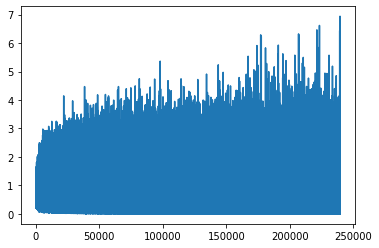

end


In [ ]:
EPOCH = 20
end_warmup = 12
freezed_bert_layer_num = 10
progressive_unfreeze = False

fold=0
kf = KFold(n_splits=5, shuffle=False)
cur_read = progress_json['cur']
for train_index, test_index in kf.split(random_index):
  # training-----------------------------------------------------------------------------------------------------------------------------
  fold+=1
  if fold<progress_json['fold']:
    continue

  if not os.path.isdir('{}/current/fold_{}'.format(path,fold)):
    os.makedirs('{}/current/fold_{}'.format(path,fold))

  losses = train_model(token_data_read,train_index, test_index, cur_read)
  cur_read = -1
  if_continue = False
  break

print("end")

#驗證/測試部分

##驗證/測試用函式：

In [ ]:
def get_best_pt(losses,n):
  plot_loss=[]
  waiting_queue=[]
  sum=0
  for i,loss in enumerate(losses):
    sum+=loss
    if i!=0 and i%save_every_pt==0:
      avg_loss=sum/save_every_pt
      plot_loss.append(avg_loss)
      sum=0
  plt.plot(range(len(plot_loss)),plot_loss)
  plt.savefig('{}/current/fold_{}/loss_batched.png'.format(path,fold))
  plt.show()
  waiting_queue = [int(i)*save_every_pt for i in list( map(plot_loss.index, heapq.nsmallest(n, plot_loss)) )]
  return waiting_queue
  
def evaluate(eval_model,X,y,loss_func):
  with torch.no_grad():
    predict = eval_model(torch.tensor(eval(X[0])).to(device),torch.tensor(eval(X[1])).to(device))
    loss = loss_func(predict.view(1), torch.tensor([y]).to(device))
  return predict,loss.item()
  
def evaluate_model(token_data_read,eval_index, eval_pt):
  confusion_matrix = [[0,0],[0,0]]

  checkpoint = torch.load( '{}/current/fold_{}/FND_model_{}.pt'.format(path,fold,eval_pt))
  eval_model = FakeNewsDetection().to(device)
  eval_model.load_state_dict(checkpoint['model_state_dict'])

  loss_func = nn.BCELoss()
  eval_model.eval()
  total_loss=0
  cur_eval=0
  start_eval = time.time()

  for i in eval_index:
    predict,loss = evaluate(eval_model,token_data_read[random_index_read[i]][:-3],float(token_data_read[random_index_read[i]][-3]),loss_func)
    total_loss+=loss
    confusion_matrix[int(token_data_read[random_index_read[i]][-3])][predict>0.5]+=1
    if cur_eval%10==0:
      print("num in waiting_queue: {}".format(temp_waiting_queue_num))
      progress(start_eval,cur_eval,len(eval_index),total_loss/(cur_eval+1),0)
    cur_eval+=1
    
  accuracy = (confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[0][1]+confusion_matrix[1][0]+confusion_matrix[1][1])
  if confusion_matrix[1][1]+confusion_matrix[0][1]==0:
    precision = "undefine"
  else:
    precision = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1])
  if confusion_matrix[1][1]+confusion_matrix[1][0]==0:
    recall = "undefine"
  else:
    recall = confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
  if precision=="undefine" or recall=="undefine":
    F1 = "undefine"
  else:
    F1 = 2*precision*recall/(precision+recall)
  print("average loss: {}".format(total_loss/len(eval_index)))
  print("confusion_matrix: {}".format(confusion_matrix))
  print(" Accuracy: {}".format(accuracy))
  print(" Precision: {}".format(precision))
  print(" Recall: {}".format(recall))
  print("F1: {}".format(F1))
  return pd.DataFrame({'num_pt':[eval_pt],'Avg_Loss':[total_loss/len(eval_index)],'Accuracy':[accuracy],'Precision':[precision],'Recall':[recall],'F1':[F1]})

##驗證部分

###驗證前讀檔：

In [ ]:
from sklearn.model_selection import KFold
token_data_read_pd = pd.read_csv(path+"/"+subject+"_token_data_bert_train.csv")
# token_data_read_pd = token_data_read_pd[token_data_read_pd["text_len"]<250]
token_data_read = token_data_read_pd.to_numpy() 

f = open('{}/current/random.txt'.format(path), 'r')
random_index_read = [int(i) for i in list(f.read().split("\n")[:-1])]
f.close()

if_continue = os.path.isfile('{}/current/eva_progress.json'.format(path))
if if_continue:
  with open('{}/current/eva_progress.json'.format(path), 'r') as progress_json_file:
    progress_json = json.load(progress_json_file)
else:
  progress_json = {'fold':0,'temp_waiting_queue_num':0}

evaluate_or_train = 1  # 0 = training set, 1 = evaluating set
best_n = 10
waiting_queue_begin = 0
waiting_queue_end = best_n

###驗證：

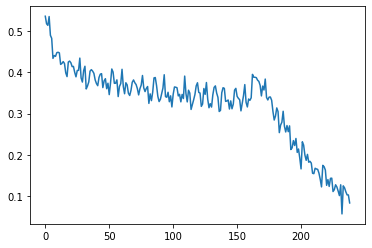

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero

num in waiting_queue: 40
0m 0s (- INF) (0.0%)
loss = 0.02843920886516571
num in waiting_queue: 40
0m 1s (- 8m 31s) (0.24360535931790497%)
loss = 0.30762062887449493
num in waiting_queue: 40
0m 2s (- 7m 42s) (0.48721071863580995%)
loss = 0.4418680599857388
num in waiting_queue: 40
0m 2s (- 6m 21s) (0.730816077953715%)
loss = 0.46794347242347056
num in waiting_queue: 40
0m 4s (- 8m 16s) (0.9744214372716199%)
loss = 0.4284338680686565
num in waiting_queue: 40
0m 6s (- 8m 22s) (1.2180267965895248%)
loss = 0.46200089877033057
num in waiting_queue: 40
0m 6s (- 7m 38s) (1.46163215590743%)
loss = 0.45927083078909237
num in waiting_queue: 40
0m 7s (- 7m 17s) (1.705237515225335%)
loss = 0.4320163969507992
num in waiting_queue: 40
0m 8s (- 7m 31s) (1.9488428745432398%)
loss = 0.41294616941408613
num in waiting_queue: 40
0m 10s (- 7m 43s) (2.192448233861145%)
loss = 0.408044433743171
num in waiting_queue: 40
0m 11s (- 7m 21s) (2.4360535931790497%)
loss = 0.3929946722398226
num in waiting_queue: 40

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 41
0m 0s (- INF) (0.0%)
loss = 0.004457439295947552
num in waiting_queue: 41
0m 1s (- 7m 1s) (0.24360535931790497%)
loss = 0.16542038103480908
num in waiting_queue: 41
0m 2s (- 7m 19s) (0.48721071863580995%)
loss = 0.3702314571211381
num in waiting_queue: 41
0m 2s (- 6m 11s) (0.730816077953715%)
loss = 0.32890842702510137
num in waiting_queue: 41
0m 5s (- 8m 29s) (0.9744214372716199%)
loss = 0.2731425478407068
num in waiting_queue: 41
0m 6s (- 8m 43s) (1.2180267965895248%)
loss = 0.30411250320920613
num in waiting_queue: 41
0m 7s (- 7m 59s) (1.46163215590743%)
loss = 0.3406741986257314
num in waiting_queue: 41
0m 7s (- 7m 39s) (1.705237515225335%)
loss = 0.31514148857824925
num in waiting_queue: 41
0m 9s (- 7m 58s) (1.9488428745432398%)
loss = 0.293623822617609
num in waiting_queue: 41
0m 11s (- 8m 12s) (2.192448233861145%)
loss = 0.3057201675709931
num in waiting_queue: 41
0m 11s (- 7m 50s) (2.4360535931790497%)
loss = 0.3072942187099044
num in waiting_queue: 41


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 42
0m 0s (- INF) (0.0%)
loss = 0.005385150667279959
num in waiting_queue: 42
0m 1s (- 7m 7s) (0.24360535931790497%)
loss = 0.10429033154452388
num in waiting_queue: 42
0m 2s (- 7m 21s) (0.48721071863580995%)
loss = 0.354429497516581
num in waiting_queue: 42
0m 2s (- 6m 13s) (0.730816077953715%)
loss = 0.3618587069851797
num in waiting_queue: 42
0m 5s (- 8m 31s) (0.9744214372716199%)
loss = 0.30212734802626073
num in waiting_queue: 42
0m 6s (- 8m 44s) (1.2180267965895248%)
loss = 0.39490222178089124
num in waiting_queue: 42
0m 7s (- 8m 0s) (1.46163215590743%)
loss = 0.39936996046377377
num in waiting_queue: 42
0m 7s (- 7m 40s) (1.705237515225335%)
loss = 0.36387167201692266
num in waiting_queue: 42
0m 9s (- 7m 58s) (1.9488428745432398%)
loss = 0.3318679333049344
num in waiting_queue: 42
0m 11s (- 8m 12s) (2.192448233861145%)
loss = 0.3490991250325281
num in waiting_queue: 42
0m 11s (- 7m 50s) (2.4360535931790497%)
loss = 0.3492077854969124
num in waiting_queue: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 43
0m 0s (- INF) (0.0%)
loss = 0.0070768073201179504
num in waiting_queue: 43
0m 1s (- 7m 9s) (0.24360535931790497%)
loss = 0.157139692095701
num in waiting_queue: 43
0m 2s (- 7m 22s) (0.48721071863580995%)
loss = 0.3336146090822738
num in waiting_queue: 43
0m 2s (- 6m 15s) (0.730816077953715%)
loss = 0.3197051721189411
num in waiting_queue: 43
0m 5s (- 8m 34s) (0.9744214372716199%)
loss = 0.2757845424092943
num in waiting_queue: 43
0m 6s (- 8m 47s) (1.2180267965895248%)
loss = 0.3704477676016954
num in waiting_queue: 43
0m 7s (- 8m 2s) (1.46163215590743%)
loss = 0.37694740203041277
num in waiting_queue: 43
0m 8s (- 7m 42s) (1.705237515225335%)
loss = 0.34371221333768376
num in waiting_queue: 43
0m 9s (- 8m 0s) (1.9488428745432398%)
loss = 0.31494533587074663
num in waiting_queue: 43
0m 11s (- 8m 14s) (2.192448233861145%)
loss = 0.33949287042820026
num in waiting_queue: 43
0m 11s (- 7m 51s) (2.4360535931790497%)
loss = 0.3409787636978718
num in waiting_queue: 43
0

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 44
0m 0s (- INF) (0.0%)
loss = 0.008737297728657722
num in waiting_queue: 44
0m 1s (- 7m 1s) (0.24360535931790497%)
loss = 0.10303107688245787
num in waiting_queue: 44
0m 2s (- 7m 23s) (0.48721071863580995%)
loss = 0.3959405906553868
num in waiting_queue: 44
0m 2s (- 6m 13s) (0.730816077953715%)
loss = 0.3522794948282441
num in waiting_queue: 44
0m 5s (- 8m 32s) (0.9744214372716199%)
loss = 0.28776693862022423
num in waiting_queue: 44
0m 6s (- 8m 46s) (1.2180267965895248%)
loss = 0.34097842598680916
num in waiting_queue: 44
0m 7s (- 8m 1s) (1.46163215590743%)
loss = 0.3672268641482825
num in waiting_queue: 44
0m 8s (- 7m 42s) (1.705237515225335%)
loss = 0.3476468216034282
num in waiting_queue: 44
0m 9s (- 8m 1s) (1.9488428745432398%)
loss = 0.3128273128646851
num in waiting_queue: 44
0m 11s (- 8m 15s) (2.192448233861145%)
loss = 0.3076776336842718
num in waiting_queue: 44
0m 11s (- 7m 52s) (2.4360535931790497%)
loss = 0.3192090893424771
num in waiting_queue: 44
0m

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 45
0m 0s (- INF) (0.0%)
loss = 0.012336517684161663
num in waiting_queue: 45
0m 1s (- 7m 5s) (0.24360535931790497%)
loss = 0.1255443537004546
num in waiting_queue: 45
0m 2s (- 7m 19s) (0.48721071863580995%)
loss = 0.4048419933561014
num in waiting_queue: 45
0m 2s (- 6m 11s) (0.730816077953715%)
loss = 0.397167032702841
num in waiting_queue: 45
0m 5s (- 8m 28s) (0.9744214372716199%)
loss = 0.3194936319231624
num in waiting_queue: 45
0m 6s (- 8m 43s) (1.2180267965895248%)
loss = 0.34781540836225827
num in waiting_queue: 45
0m 7s (- 8m 0s) (1.46163215590743%)
loss = 0.352665253609541
num in waiting_queue: 45
0m 7s (- 7m 40s) (1.705237515225335%)
loss = 0.3377078978515322
num in waiting_queue: 45
0m 9s (- 7m 59s) (1.9488428745432398%)
loss = 0.31162893313075196
num in waiting_queue: 45
0m 11s (- 8m 13s) (2.192448233861145%)
loss = 0.3145706920250022
num in waiting_queue: 45
0m 11s (- 7m 51s) (2.4360535931790497%)
loss = 0.3200663824745518
num in waiting_queue: 45
0m 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 46
0m 0s (- INF) (0.0%)
loss = 0.010279920883476734
num in waiting_queue: 46
0m 1s (- 6m 53s) (0.24360535931790497%)
loss = 0.27864402006591926
num in waiting_queue: 46
0m 2s (- 7m 17s) (0.48721071863580995%)
loss = 0.4289084570648681
num in waiting_queue: 46
0m 2s (- 6m 10s) (0.730816077953715%)
loss = 0.4603261342685249
num in waiting_queue: 46
0m 5s (- 8m 31s) (0.9744214372716199%)
loss = 0.38082467981829965
num in waiting_queue: 46
0m 6s (- 8m 45s) (1.2180267965895248%)
loss = 0.41766541589316275
num in waiting_queue: 46
0m 7s (- 8m 1s) (1.46163215590743%)
loss = 0.4108125284890507
num in waiting_queue: 46
0m 7s (- 7m 41s) (1.705237515225335%)
loss = 0.37608954389612387
num in waiting_queue: 46
0m 9s (- 7m 59s) (1.9488428745432398%)
loss = 0.3528301841536261
num in waiting_queue: 46
0m 11s (- 8m 14s) (2.192448233861145%)
loss = 0.3618648658790575
num in waiting_queue: 46
0m 11s (- 7m 51s) (2.4360535931790497%)
loss = 0.35849494919858615
num in waiting_queue: 4

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 47
0m 0s (- INF) (0.0%)
loss = 0.005559131968766451
num in waiting_queue: 47
0m 1s (- 6m 54s) (0.24360535931790497%)
loss = 0.19957596523983573
num in waiting_queue: 47
0m 2s (- 7m 11s) (0.48721071863580995%)
loss = 0.39555268394871657
num in waiting_queue: 47
0m 2s (- 6m 5s) (0.730816077953715%)
loss = 0.3580180274345161
num in waiting_queue: 47
0m 4s (- 8m 22s) (0.9744214372716199%)
loss = 0.30165527626678984
num in waiting_queue: 47
0m 6s (- 8m 36s) (1.2180267965895248%)
loss = 0.4130070822692348
num in waiting_queue: 47
0m 7s (- 7m 54s) (1.46163215590743%)
loss = 0.42270533171039626
num in waiting_queue: 47
0m 7s (- 7m 34s) (1.705237515225335%)
loss = 0.3908773131642333
num in waiting_queue: 47
0m 9s (- 7m 53s) (1.9488428745432398%)
loss = 0.3584227791188262
num in waiting_queue: 47
0m 10s (- 8m 7s) (2.192448233861145%)
loss = 0.3810841495089315
num in waiting_queue: 47
0m 11s (- 7m 45s) (2.4360535931790497%)
loss = 0.3743020648062967
num in waiting_queue: 47


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 48
0m 0s (- INF) (0.0%)
loss = 0.008263062685728073
num in waiting_queue: 48
0m 1s (- 7m 2s) (0.24360535931790497%)
loss = 0.20459175067530436
num in waiting_queue: 48
0m 2s (- 7m 16s) (0.48721071863580995%)
loss = 0.30651082945544095
num in waiting_queue: 48
0m 2s (- 6m 8s) (0.730816077953715%)
loss = 0.3125268847591454
num in waiting_queue: 48
0m 4s (- 8m 26s) (0.9744214372716199%)
loss = 0.26285454634542965
num in waiting_queue: 48
0m 6s (- 8m 40s) (1.2180267965895248%)
loss = 0.32385019302669477
num in waiting_queue: 48
0m 7s (- 7m 56s) (1.46163215590743%)
loss = 0.3448803230116266
num in waiting_queue: 48
0m 7s (- 7m 36s) (1.705237515225335%)
loss = 0.33213775331633244
num in waiting_queue: 48
0m 9s (- 7m 55s) (1.9488428745432398%)
loss = 0.3070117121341029
num in waiting_queue: 48
0m 10s (- 8m 9s) (2.192448233861145%)
loss = 0.31418465345632285
num in waiting_queue: 48
0m 11s (- 7m 47s) (2.4360535931790497%)
loss = 0.3132878808260868
num in waiting_queue: 48

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 49
0m 0s (- INF) (0.0%)
loss = 0.016895785927772522
num in waiting_queue: 49
0m 1s (- 7m 5s) (0.24360535931790497%)
loss = 0.2799575425134125
num in waiting_queue: 49
0m 2s (- 7m 20s) (0.48721071863580995%)
loss = 0.40133931912437437
num in waiting_queue: 49
0m 2s (- 6m 11s) (0.730816077953715%)
loss = 0.36880920744020373
num in waiting_queue: 49
0m 5s (- 8m 28s) (0.9744214372716199%)
loss = 0.32688161822194917
num in waiting_queue: 49
0m 6s (- 8m 41s) (1.2180267965895248%)
loss = 0.33766037518359426
num in waiting_queue: 49
0m 7s (- 7m 57s) (1.46163215590743%)
loss = 0.35679112762579174
num in waiting_queue: 49
0m 7s (- 7m 37s) (1.705237515225335%)
loss = 0.3411456370254008
num in waiting_queue: 49
0m 9s (- 7m 55s) (1.9488428745432398%)
loss = 0.31842707749456167
num in waiting_queue: 49
0m 10s (- 8m 9s) (2.192448233861145%)
loss = 0.31561127307077685
num in waiting_queue: 49
0m 11s (- 7m 47s) (2.4360535931790497%)
loss = 0.3144337259196114
num in waiting_queue: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


num in waiting_queue: 50
0m 0s (- INF) (0.0%)
loss = 0.030521918088197708
num in waiting_queue: 50
0m 1s (- 6m 52s) (0.24360535931790497%)
loss = 0.19789448964663528
num in waiting_queue: 50
0m 2s (- 7m 10s) (0.48721071863580995%)
loss = 0.38197588609043687
num in waiting_queue: 50
0m 2s (- 6m 4s) (0.730816077953715%)
loss = 0.3187625872857508
num in waiting_queue: 50
0m 4s (- 8m 22s) (0.9744214372716199%)
loss = 0.2704805611496473
num in waiting_queue: 50
0m 6s (- 8m 36s) (1.2180267965895248%)
loss = 0.3084517217825587
num in waiting_queue: 50
0m 7s (- 7m 53s) (1.46163215590743%)
loss = 0.347657911116868
num in waiting_queue: 50
0m 7s (- 7m 34s) (1.705237515225335%)
loss = 0.35177656022084114
num in waiting_queue: 50
0m 9s (- 7m 52s) (1.9488428745432398%)
loss = 0.32163659550743984
num in waiting_queue: 50
0m 10s (- 8m 6s) (2.192448233861145%)
loss = 0.3305801511460731
num in waiting_queue: 50
0m 11s (- 7m 44s) (2.4360535931790497%)
loss = 0.33656297424706716
num in waiting_queue: 50


In [ ]:
results = pd.DataFrame({'num_pt':[],'Avg_Loss':[],'Accuracy':[],'Precision':[],'Recall':[],'F1':[]})
fold=0
last_waiting_queue_num = progress_json['temp_waiting_queue_num']
kf = KFold(n_splits=5, shuffle=False)
for train_index, eva_index in kf.split(random_index_read):
  # evaluating-----------------------------------------------------------------------------------------------------------------------------
  fold+=1
  if fold<progress_json['fold']:
    continue
  #建立當前fold的輸出檔案
  if not os.path.isfile('{}/current/fold_{}/eva_result.csv'.format(path,fold)):
    pd.DataFrame({'num_pt':[],'Avg_Loss':[],'Accuracy':[],'Precision':[],'Recall':[],'F1':[]}).to_csv('{}/current/fold_{}/eva_result.csv'.format(path,fold),index=False)
  if not os.path.isfile('{}/current/fold_{}/train_result.csv'.format(path,fold)):
    pd.DataFrame({'num_pt':[],'Avg_Loss':[],'Accuracy':[],'Precision':[],'Recall':[],'F1':[]}).to_csv('{}/current/fold_{}/train_result.csv'.format(path,fold),index=False)
  #讀取loss並選出較好的節點
  f = open('{}/current/fold_{}/loss.txt'.format(path,fold), 'r')
  losses = [float(i) for i in list(f.read().split("\n")[:-1])]
  f.close()
  waiting_queue=get_best_pt(losses,best_n)

  #迭代候選節點
  temp_waiting_queue_num = 0
  for eval_pt in waiting_queue[waiting_queue_begin:waiting_queue_end]:
    temp_waiting_queue_num+=1
    #走到當前進度
    if temp_waiting_queue_num<=last_waiting_queue_num:
      continue

    # evaluate error
    if evaluate_or_train:  
      # 測試
      result = evaluate_model(token_data_read, eva_index,eval_pt)
      # 結果輸出
      print("start writing result")
      result.to_csv('{}/current/fold_{}/eva_result.csv'.format(path,fold), mode='a', header=False,index=False)
    # training error
    else:  
      # 測試
      result = evaluate_model(token_data_read, train_index,eval_pt)
      # 結果輸出
      print("start writing result")
      result.to_csv('{}/current/fold_{}/train_result.csv'.format(path,fold), mode='a', header=False,index=False)

    #更新進度
    print("start saving progress")
    with open('{}/current/eva_progress.json'.format(path), 'w') as progress_json_file:
        json.dump({'fold':fold,'temp_waiting_queue_num':temp_waiting_queue_num}, progress_json_file)
    print("done saving")

    results = results.append(result, ignore_index=True)
  print(results)

  last_waiting_queue_num=0
  break

print("end")


##測試部分

###測試前讀檔

In [ ]:
from sklearn.model_selection import KFold
token_data_read_pd = pd.read_csv(path+"/"+subject+"_token_data_bert_test.csv")
# token_data_read_pd = token_data_read_pd[token_data_read_pd["text_len"]<250]
token_data_read = token_data_read_pd.to_numpy() 

random_index_read = list(range(token_data_read.shape[0]))

if_continue = os.path.isfile('{}/current/test_progress.json'.format(path))
if if_continue:
  with open('{}/current/test_progress.json'.format(path), 'r') as progress_json_file:
    progress_json = json.load(progress_json_file)
else:
  progress_json = {'fold':0,'temp_waiting_queue_num':0}

best_n = 10
waiting_queue_begin = 0
waiting_queue_end = best_n

###測試

In [ ]:
results = pd.DataFrame({'num_pt':[],'Avg_Loss':[],'Accuracy':[],'Precision':[],'Recall':[],'F1':[]})
last_waiting_queue_num = progress_json['temp_waiting_queue_num']
for fold in range(1,6):
  # testing-----------------------------------------------------------------------------------------------------------------------------
  if fold<progress_json['fold']:
    continue
  #建立當前fold的輸出檔案
  if not os.path.isfile('{}/current/fold_{}/test_result.csv'.format(path,fold)):
    pd.DataFrame({'num_pt':[],'Avg_Loss':[],'Accuracy':[],'Precision':[],'Recall':[],'F1':[]}).to_csv('{}/current/fold_{}/test_result.csv'.format(path,fold),index=False)
  #讀取loss並選出較好的節點
  f = open('{}/current/fold_{}/loss.txt'.format(path,fold), 'r')
  losses = [float(i) for i in list(f.read().split("\n")[:-1])]
  f.close()
  waiting_queue=get_best_pt(losses,best_n)

  #迭代候選節點
  temp_waiting_queue_num = 0
  for test_pt in waiting_queue[waiting_queue_begin:waiting_queue_end]:
    temp_waiting_queue_num+=1
    #走到當前進度
    if temp_waiting_queue_num<=last_waiting_queue_num:
      continue

    # testing error
    # 測試
    result = evaluate_model(token_data_read, list(range(token_data_read.shape[0])),test_pt)
    # 結果輸出
    print("start writing result")
    result.to_csv('{}/current/fold_{}/test_result.csv'.format(path,fold), mode='a', header=False,index=False)

    #更新進度
    print("start saving progress")
    with open('{}/current/test_progress.json'.format(path), 'w') as progress_json_file:
        json.dump({'fold':fold,'temp_waiting_queue_num':temp_waiting_queue_num}, progress_json_file)
    print("done saving")

    results = results.append(result, ignore_index=True)
  print(results)

  last_waiting_queue_num=0
  break

print("end")
